# 16 - SVD
- 16.1 Singular value decomposition
- 16.2 Computing the SVD
- 16.3 Singular values and eigenvalues
- 16.4 SVD of a symmetric matrix
- 16.5 SVD and the four subspaces
- 16.6 SVD and matrix rank
- 16.7 SVD spectral theory
- 16.8 Low-rank approximations
- 16.9 Normalizing singular values
- 16.10 Condition number of a matrix
- 16.11 SVD and the matrix inverse
- 16.12 Moore-Penrose pseudoinverse, part 2
- 16.13 Code challenges
- 16.14 Code solutions

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

## 16.1 Singular value decomposition
Singular value decomposition (SVD) is a generalization of eigendecomposition for non-square matrices

### Recap: Diagonalization (_15.4_)
Eigendecompositions find a set of basis vectors for a matrix such that the matrix is diagonal to that basis.

The matrix $A$ can be factorized into the product of eigenvalues with the diagonal matrix $\Lambda$ wedged between the eigenvector matrices $V$ and $V^{-1}$.

$$
A = V \Lambda V^-{1}
$$

The diagonalization operations can be conceptualized as a rotation, followed by a stretch, followed by another rotation.

### Recap: Symmetric Diagonalization (_15.8_)
When the matrix $A$ is symmetric, then several additional conclusions apply.
1. Eigenvectors are orthogonal. This simplifies the factorization by replacing $V^{-1}$ with $V^T$.
2. Eigenvalues are real-valued.
3. Diagonalization always exists.

### Singular Value Decomposition
Singular value decomposition (SVD) diagonalizes the symmetric (square) matrix formed by the product $A A^T$ or $A^T A$.

The matrix $A$ is factorized into the left singular vectors $U$, a diagonal matrix $\Sigma$, and the right singular vectors $V^T$.

$$
A = U \Sigma V^T
$$

Similar to diagonalization, the SVD can be interpreted as a geometrical transformation of a rotation $V^T$, followed by stretch $\Sigma$, followed by another rotation $U$.

Notes
- The left singular vectors $U$ form a orthonormal basis in $\mathbb{R}^m$ which includes the column space $C(A)$ and the left null space $N(A^T)$.
- The right singular vectors $V$ form a orthonormal basis in $\mathbb{R}^n$ which includes the rows space $R(A)$ and the null space $N(A)$.
- The singular values $\Sigma$ are always non-negative.

## 16.2 Computing the SVD

### Factorize $A$ into $U$, $\Sigma$ and $V$
1. Pick one of the following approaches based on whichever of $A^T A$ and $A A^T$ produces a matrix of smaller dimensions.
    1. For tall matrices compute the eigendecomposition of $\text{eig}(A^T A)$ to find $\Sigma$ and $V$.
    2. For wide matrices compute the eigendecomposition of $\text{eig}(A A^T)$ to find $\Sigma$ and $U$.
2. Solve for the remaining unknown matrix depending on the choice of 1A or 1B.
    1. Solve for $U = A V \Sigma^{-1}$.
    2. Solve for $V^T = \Sigma^{-1} U^T A$.

Notes
- Singular vectors $U$ and $V$ must be normalized by eigendecomposition to produce accurate factorization.
- Unlike diagonalization, the signs of $U$ and $V$ are significant.
- Most implementations of the SVD return the singular values $\Sigma$ in decreasing order, but this is choice of implementation and not intrinsic to the algorithm. 

In [2]:
def svd(A):
    """
    svd returns the singular value decomposition of the matrix A as U Sigma V^T 

    :param A: numpy.ndarray           Matrix A
    :return: tuple of numpy.ndarray   Matrix U, Sigma, V^T
    """
    m, n = A.shape
    if m <= n:
        # Wide matrix, dimension of A A^T is smaller.
        AAT = A @ A.T

        # Find eigendecomposition of symmetric matrix A A^T.
        L, U = np.linalg.eig(AAT)

        # Solve for V^T = Sigma^-1 U^T A.
        Sigma = np.diag(L)
        Sigmainv = np.diag(1./L)
        VT = Sigmainv @ U.T @ A
    else:
        # Tall matrix, dimension of A^T A is smaller.
        ATA = A.T @ A

        # Find eigendecomposition of symmetric matrix A^T A.
        L, V = np.linalg.eig(ATA)
        VT = V.T

        # Solve for U = A V Sigma^-1.
        Sigma = np.diag(L)
        Sigmainv = np.diag(1./L)
        U = A @ V @ Sigmainv

    return U, Sigma, VT

In [3]:
# Find SVD of wide matrix A.
m, n = 4, 7
Awide = np.random.random((m,n))

U, Sigma, VT = svd(Awide)
Aprime = U @ Sigma @ VT

# Verify A = U Sigma V^T.
np.testing.assert_almost_equal(Aprime, Awide)

In [4]:
# Find SVD of tall matrix A.
m, n = 7, 4
Atall = np.random.random((m,n))

U, Sigma, VT = svd(Atall)
Aprime = U @ Sigma @ VT

# Verify A = U Sigma V^T.
np.testing.assert_almost_equal(Aprime, Atall)

## 16.3 Singular values and eigenvalues
In general the eigenvalues and singular values will not be the same.

If $A$ is symmetric $A = A^T$, then the eigenvalues and singular values are the same.

$$
\Lambda(\text{eig}(A^TA)) = \Sigma
$$

In [5]:
n = 4
A = np.random.random((n,n))
ATA = A.T @ A

L, V = np.linalg.eig(ATA)
U, Sigma, VT = np.linalg.svd(ATA)

# NOTE(mmorais): sort eigenvalues in descending order to compare with Sigma.
L = np.flip(np.sort(L))

# Verify that L = Sigma when A is symmetric.
np.testing.assert_almost_equal(L, Sigma)

## 16.4 SVD of a symmetric matrix
If $A$ is symmetric $A = A^T$, then the left and right singular vectors are the same $U = V$ and the factorization is simplified.

$$
A = U \Sigma U^T
$$

In [6]:
m, n = 7, 4
A = np.random.random((m,n))
ATA = A.T @ A

U, Sigma, VT = np.linalg.svd(ATA)

# Verify that U = V when A is symmetric.
np.testing.assert_almost_equal(U, VT.T)

## 16.5 SVD and the four subspaces

### Left Singular Matrix $U$
The left singular matrix $U$ is a subspace in $\mathbb{R}^M$ that includes the column space and left null space.

$$
\mathbb{R}^M = \text{dim}(C(A)) + \text{dim}(N(A^T))
$$

Notes
- Recall from (_8.9_) that the column space and left null space are orthogonal complements.

### Right Singular Matrix $V$
The right singular matrix $V$ is a subspace in $\mathbb{R}^N$ that includes the row space and null space.

$$
\mathbb{R}^N = \text{dim}(R(A)) + \text{dim}(N(A))
$$

Notes
- Recall from (_8.9_) that the row space and null space are orthogonal complements.

## 16.6 SVD and matrix rank
Rank of matrix $A$ equals the number of nonzero (nnz) singular values.

$$
\text{rank}(A) = \text{nnz}(\lambda_1, \lambda_2, \dots, \lambda_k)
$$

Notes
- Recall from (_8.10_) that rank is a property of a matrix and dimension refers to the number of vectors in a subspace.

### Rank and Dimension
The relationship between the rank of a matrix and the dimension of the row and column space still applies.

$$
\text{rank}(A) = \text{dim}(C(A)) = \text{dim}(R(A))
$$

In [7]:
def rank(m, n, r):
    """
    rank returns a matrix of random values with dimensions m \times n and rank r 

    :param m: int            Number of rows.
    :param n: int            Number of columns.
    :param r: int            Rank.
    :return: numpy.ndarray   Matrix with dimensions m \times n and rank r.
    """
    assert r <= m and r <=n

    A = np.random.random((m, r))
    B = np.random.random((r, n))
    return A @ B


m, n, r = 7, 4, 3
A = rank(m, n, r)

r = np.linalg.matrix_rank(A)
U, Sigma, VT = np.linalg.svd(A)

# Dynamically set the threshold for counting singular values.
tol = Sigma.max() * np.max(A.shape) * np.finfo(float).eps 

# Verify that the number of nonzero singular values corresponds to rank.
np.testing.assert_equal(r, np.count_nonzero(Sigma > tol))

## 16.7 SVD spectral theory

### Recap: Spectral Theory (_15.10_)
Spectral theory states that any matrix can be reconstructed from the sum of rank-1 matrices of outer products.

For square matrices, the outer products are formed from the columns of the eigenvectors and its' inverse scaled by each eigenvalue.

### Spectral Theory For SVD
Spectral theory in the context of SVD takes on new meaning since the outer products can be ordered by the magnitude of the singular values.
- Relatively small singular values will contribute little to the reconstruction of the original matrix.

The matrix $A$ can be reconstructed from the sum of $r$ rank-1 matrices formed from the outer products of the columns of $U$, $\Sigma$, and $V$.

$$
A = \sum_{i=1}^r u_i \sigma_i v^T_i
$$

Notes
- Only the $r$ nonzero singular values are needed to reconstruct the matrix, the remaining columns of $U$ and rows of $V$ are in the null spaces.
    - Columns of $U$ that multiply zero-valued singular values are in the left null space and are not included in the reconstruction.
    - Rows of $V$ that multiply zero-valued singular values are in the null space and are not included in the reconstruction.

### Interpreting $U$, $V$, and $\Sigma$
Norm of the columns of $U$ and $V$ are always 1 since both matrices are orthogonal.
- Interpretation: $U$ and $V$ orient a single dimension of the spectrum.

Singular values in $\Sigma$ are always non-negative.
- Interpretation: The singular value $\sigma_i$ provides the magnitude along a single dimension of the spectrum.

In [8]:
def reconstruct(U, Sigma, VT):
    """
    reconstruct A from SVD using Spectral Theory

    :param U: numpy.ndarray      Matrix U of left singular vectors
    :param Sigma: numpy.ndarray  Matrix Sigma of singular values
    :param VT: numpy.ndarray     Matrix VT of right singular vectors
    :return: numpy.ndarray       Matrix A
    """
    m, n = U.shape[0], VT.shape[1]
    A = np.zeros((m,n))
    for i in range(Sigma.size):
        A += Sigma[i] * np.outer(U[:,i], VT[i,:])
    return A

In [9]:
# Reconstruct tall matrix.
m, n = 7, 4
Atall = np.random.random((m,n))

U, Sigma, VT = np.linalg.svd(Atall)

# Reconstruct A from SVD.
Aprime = reconstruct(U, Sigma, VT)

# Verify that A is reconstructed from SVD.
np.testing.assert_almost_equal(Aprime, Atall)

In [10]:
# Reconstruct wide matrix.
m, n = 4, 7
Awide = np.random.random((m,n))

U, Sigma, VT = np.linalg.svd(Awide)

# Reconstruct A from SVD.
Aprime = reconstruct(U, Sigma, VT)

# Verify that A is reconstructed from SVD.
np.testing.assert_almost_equal(Aprime, Awide)

## 16.8 Low-rank approximations
Low-rank approximations take advantage of the fact that relatively small singular values contribute little to the reconstruction of the original matrix.

### Scree Plot
A scree plot can be used to select the $k$ largest of the $r$ nonzero singular values.
* Possible method: Selecting the first $k$ singular values whose cumulative sum captures some percentage threshold of the sum of all singular values.

### Why Use Low-Rank Approximations
1. Increase the signal-to-noise ratio (SNR) of a dataset.
    * Truncate small singular values when those small singular values are associated with noise.
2. ML feature engineering.
    * More efficient to train machine learning models on low-rank approximations rather than original dataset.
3. Compression.
    * Store only the first $k$ columns of $U$ and $V$ in order to reconstruct $A$ rather than storing the original matrix.

## 16.9 Normalizing singular values
Singular values are not comparable between matrices, but by normalizing singular values to their sum, we can make inferences about relative importance.

$$
\hat{\sigma}_i = \frac{\sigma_i}{\sum_{j=1}^r \sigma_j}
$$

In [11]:
m, n, alpha = 7, 4, 100
A = np.random.random((m,n))
B = alpha * A

# Find the singular values of matrix A and B.
_, Sigma_A, _ = np.linalg.svd(A)
_, Sigma_B, _ = np.linalg.svd(B)

# Verify that the singular values of B are scaled by alpha.
np.testing.assert_almost_equal(Sigma_A * alpha, Sigma_B)

# Normalize the singular values.
Sigma_A_norm = Sigma_A / np.sum(Sigma_A)
Sigma_B_norm = Sigma_B / np.sum(Sigma_B)

# Verify that the normalized singular values are equal.
np.testing.assert_almost_equal(Sigma_A_norm, Sigma_B_norm)

## 16.10 Condition number of a matrix

### Interpretation
Condition number of matrix measures how much the matrix will stretch another matrix.

Notes
* Larger values imply more stretching and matrix is closer to singular. 
* Condition number of identity matrix is 1 e.g. $\text{cond}(I) = 1$
* Condition number of orthogonal matrix is 1 e.g. $\text{cond}(Q) = 1$

### Condition Number from Singular Values
Ratio of largest to smallest singular values provide a measure of condition number.

$$
\text{cond}(A) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}
$$

### Other Forms of Condition Number
Another form of the condition number is the product of the norm of a matrix and its inverse.

$$
\text{cond}(A) = \lVert A \rVert \lVert A^{-1} \rVert
$$

Notes
* Since the inverse is required and matrices with large condition number are nearly singular, this form is useful in theory but not practice.
* Numerical value of the condition number computed using this method is not comparable to singular value method.

In [12]:
n = 4
A = np.random.random((n,n))

_, Sigma, _ = np.linalg.svd(A)

# Demonstrate the numerical value of condition number depends on method used to compute.
cond = np.max(Sigma) / np.min(Sigma)
print(f'cond(A): {cond}')

cond2 = np.linalg.norm(A, ord='fro') * np.linalg.norm(np.linalg.inv(A), ord='fro')
print(f'cond(A): {cond2}')

cond(A): 13.662391180129461
cond(A): 18.39615732066634


## 16.11 SVD and the matrix inverse
Inverse of the factorization of SVD always exists since $U$ and $V$ are orthogonal and $\Sigma$ is diagonal.

$$
A^{-1} = (U \Sigma V^T)^{-1} = V \Sigma^{-1} U^T
$$

Notes
* Relies on the property that the inverse of a product of matrices is equal to the property of the inverses in reverse (_Recall from 6.4: LIVE EVIL_).

## 16.12 Moore-Penrose pseudoinverse, part 2
Pseudoinverse $A^+$ is found from the inverse of the factorization of the SVD shown in previous section.

$$
A^+ = V \Sigma^{-1} U^T
$$

Notes
* Recall from _(12.2)_ that the inverse of the diagonal matrix $\Sigma^{-1}$ is the reciprocal of the diagonal elements.
    * For numerical stability, take only the reciprocal of singular values larger than the threshold $T = \text{max}(\Sigma) \times \text{max}(m,n) \times \epsilon$.

In [13]:
m, n = 7, 4
A = np.random.random((m,n))
Apinv = np.linalg.pinv(A)

# Factorize A into SVD.
U, Sigma, VT = np.linalg.svd(A)

# Compute the pseudoinverse from inverse of the product of factorization.
Aplus = VT.T @ np.diag(1./Sigma) @ U.T[:n,:]

# Verify that the explicit matrix pseudoinverse equals the pseudoinverse.
np.testing.assert_almost_equal(Aplus, Apinv)

## 16.13 Code challenges

> In Chapter 13 you learned about economy QR decomposition which can be useful for large tall matrices. There is a comparable economy version of the SVD. Your goal here is to figure out what that means. First generate three random matrices: square, wide, and tall. Then run the full SVD to confirm that the sizes of the SVD matrices match your expectations. Finally, run the economy SVD on all three matrices and compare the sizes to the full SVD.

Notes
* Reconstructing nonsquare matrix A from numpy _full_ svd output requires special handling.
    * Use a subset of the rows of $V^T$ for wide matrices.
    * Use a subset of the columns of $U$ for tall matrices.

In [14]:
# Generate random square matrix.
Asquare = np.random.random((4,4))

# Square matrix 4x4: Full SVD.
U, Sigma, VT = np.linalg.svd(Asquare)
np.testing.assert_equal((4,4), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((4,4), VT.shape)

# NOTE(mmorais): A is reconstructed directly from full svd output.
np.testing.assert_almost_equal(U @ np.diag(Sigma) @ VT, Asquare)

# Square matrix 4x4: Economy SVD.
U, Sigma, VT = np.linalg.svd(Asquare, full_matrices=False)
np.testing.assert_equal((4,4), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((4,4), VT.shape)

# NOTE(mmorais): A is reconstructed directly from economy svd output.
np.testing.assert_almost_equal(U @ np.diag(Sigma) @ VT, Asquare)

In [15]:
# Generate random wide matrix.
Awide = np.random.random((4,7))

# Wide matrix, 4x7: Full SVD.
U, Sigma, VT = np.linalg.svd(Awide)
np.testing.assert_equal((4,4), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((7,7), VT.shape)

# NOTE(mmorais): A is reconstructed from a subset of the rows in VT.
np.testing.assert_almost_equal(U @ np.diag(Sigma) @ VT[:Sigma.size,:], Awide)

# Wide matrix, 4x7: Economy SVD; first dimension of VT is truncated.
U, Sigma, VT = np.linalg.svd(Awide, full_matrices=False)
np.testing.assert_equal((4,4), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((4,7), VT.shape)

# NOTE(mmorais): A is reconstructed directly from economy svd output.
np.testing.assert_almost_equal(U @ np.diag(Sigma) @ VT, Awide)

In [16]:
# Generate random tall matrix.
Atall = np.random.random((7,4))

# Tall matrix, 7x4: Full SVD.
U, Sigma, VT = np.linalg.svd(Atall)
np.testing.assert_equal((7,7), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((4,4), VT.shape)

# NOTE(mmorais): A is reconstructed from a subset of the columns in U.
np.testing.assert_almost_equal(U[:,:Sigma.size] @ np.diag(Sigma) @ VT, Atall)

# Tall matrix, 7x4: Economy SVD; second dimension of U is truncated.
U, Sigma, VT = np.linalg.svd(Atall, full_matrices=False)
np.testing.assert_equal((7,4), U.shape)
np.testing.assert_equal(4, Sigma.size)
np.testing.assert_equal((4,4), VT.shape)

# NOTE(mmorais): A is reconstructed directly from economy svd output.
np.testing.assert_almost_equal(U @ np.diag(Sigma) @ VT, Atall)

> Obtain the three SVD matrices from eigendecomposition as described in section 16.2. Then compute the SVD of that matrix using the `svd()` function, to confirm that your results are correct. Keep in mind the discussions of sign-indeterminancy.

Notes
* More efficient to compute the eigendecomposition of $A^T A$ or $A A^T$ instead of both and derive the remaining matrices. This is implemented in the `svd()` function from section 16.2 and tested for random wide and tall matrices below. I couldn't reconstruct the original matrix by merging $U$ and $V$ from the eigendecomposition of both $A^T A$ and $A A^T$ as described in the book. This probably has something to do with normalization of eigenvectors.

In [17]:
# Generate random wide matrix.
Awide = np.random.random((4,7))

U, Sigma, VT = svd(Awide)
Aprime = U @ Sigma @ VT

np.testing.assert_almost_equal(Aprime, Awide)

In [18]:
# Generate random tall matrix.
Atall = np.random.random((7,4))

U, Sigma, VT = svd(Atall)
Aprime = U @ Sigma @ VT

np.testing.assert_almost_equal(Aprime, Atall)

> Write code to reproduce panels B and C in Figure 16.5. Confirm that the reconstructed matrix (third matrix in panel C) is equal to the original matrix. (Note: The matrix was populated with random numbers, so don't expect your results to look exactly like those in the figure.)

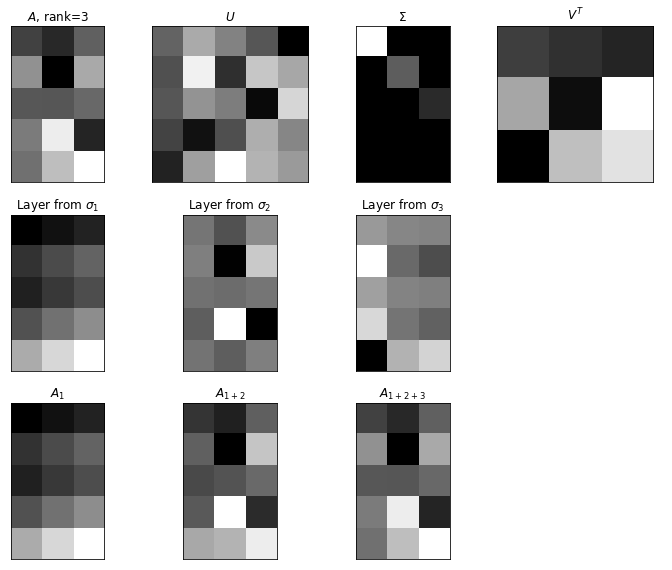

In [19]:
m, n = 5, 3
A = np.random.random((m,n))

U, Sigma, VT = np.linalg.svd(A)

# Construct an m X n matrix with Sigma along diagonals.
Sigma_matrix = np.zeros((m,n))
np.fill_diagonal(Sigma_matrix, Sigma)

# Reconstruct each layer of the original matrix.
layers = []
for i in range(n):
    A = np.zeros((m,n))
    A = Sigma[i] * np.outer(U[:,i], VT[i,:])
    layers.append(A)

# Take the cumulative sum of each layer.
cumsums = [layers[0]]
for i in range(1,n):
    A = cumsums[i-1] + layers[i]
    cumsums.append(A)

# Plot the original matrix and components of SVD.
# NOTE(mmorais): Hide ticks around images and hide axes without plot.
fig1, axes = plt.subplots(3, 4, figsize=(10,8), 
                          subplot_kw={'xticks':[], 'yticks': []})

axes[0,0].imshow(A, cmap='gray')
axes[0,0].set_title('$A$, rank=3')
axes[0,1].imshow(U, cmap='gray')
axes[0,1].set_title('$U$')
axes[0,2].imshow(Sigma_matrix, cmap='gray')
axes[0,2].set_title('$\\Sigma$')
axes[0,3].imshow(VT, cmap='gray')
axes[0,3].set_title('$V^{T}$')

axes[1,0].imshow(layers[0], cmap='gray')
axes[1,0].set_title('Layer from $\sigma_1$')
axes[1,1].imshow(layers[1], cmap='gray')
axes[1,1].set_title('Layer from $\sigma_2$')
axes[1,2].imshow(layers[2], cmap='gray')
axes[1,2].set_title('Layer from $\sigma_3$')
axes[1,3].axis('off')

axes[2,0].imshow(cumsums[0], cmap='gray')
axes[2,0].set_title('$A_{1}$')
axes[2,1].imshow(cumsums[1], cmap='gray')
axes[2,1].set_title('$A_{1+2}$')
axes[2,2].imshow(cumsums[2], cmap='gray')
axes[2,2].set_title('$A_{1+2+3}$')
axes[2,3].axis('off')

plt.tight_layout()
plt.show()

> Create a random numbers matrix with a specified condition number. For example, create a 6 X 16 random matrix with a condition number of $\kappa = 42$. Do this by creating random U and V matrices, an appropriate $\Sigma$ matrix, and then create $A = U \Sigma V^T$. Finally, compute the condition number of A to confirm that it matches what you specified.

In [20]:
def rand_maxmin_ratio(n, ratio):
    """
    rand_maxmin_ratio returns a vector of random values with given max/min ratio

    :param n: int            Size of returned vector
    :param ratio: float      Desired ratio of max/min value
    :return: numpy.ndarray   Vector of random values
    """
    x = np.random.random(n)
    maxv, minvi = np.max(x), np.argmin(x)
    scale = ratio * x[minvi]/maxv
    inds = np.r_[:minvi,minvi+1:n]
    x[inds] = scale * x[inds]
    return x


def randsvd(m, n, kappa):
    """
    randsvd returns a matrix of random values with condition number kappa

    :param m: int            Number of rows.
    :param n: int            Number of columns.
    :param kappa: float      Condition number of returned matrix.
    :return: numpy.ndarray   Matrix with dimensions m \times n.
    """
    rank = np.min([m,n])
    # Other choices for random singular values are possible.
    # For example, equally spaced values between min and max lambda where kappa = max/min.
    Sigma = rand_maxmin_ratio(rank, kappa)
    U, _ = np.linalg.qr(np.random.random((m,m)))
    V, _ = np.linalg.qr(np.random.random((n,n)))
    if m <= n:
        A = U @ np.diag(Sigma) @ V.T[:Sigma.size,:]
    else:
        A = U[:,:Sigma.size] @ np.diag(Sigma) @ V.T
    return A

In [21]:
# Generate random wide matrix.
m, n, kappa = 4, 7, 42.
Awide = randsvd(m, n, kappa)

# Verify that the shape, rank, and condition number of the matrix match expected.
np.testing.assert_equal(Awide.shape, [m,n])
np.testing.assert_equal(np.linalg.matrix_rank(Awide), m)
np.testing.assert_almost_equal(np.linalg.cond(Awide), kappa)

In [22]:
# Generate random tall matrix.
m, n, kappa = 7, 4, 42.
Atall = randsvd(m, n, kappa)

# Verify that the shape, rank, and condition number of the matrix match expected.
np.testing.assert_equal(Atall.shape, [m,n])
np.testing.assert_equal(np.linalg.matrix_rank(Atall), n)
np.testing.assert_almost_equal(np.linalg.cond(Atall), kappa)

> This and the next two challenges involve taking the SVD of a picture. A picture is represented as a matrix, with the matrix values corresponding to grayscale intensities of the pixels. We will use a picture of Einstein.
>
> After importing the image, construct a low-rank approximation using various numbers of singular values. Show the original and low-rank approximations side-by-side. Test various numbers of components and qualitatively evaluate the results.
> 
> Tip: Experiment with omitting some of the top singular values.

Credit: <a href="https://en.wikipedia.org/wiki/File:Einstein_tongue.jpg">Einstein tongue</a>

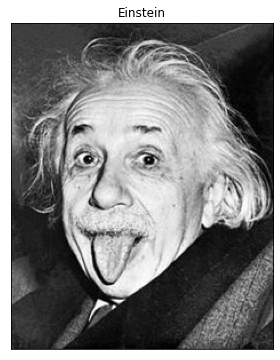

In [23]:
einstein = mpimg.imread("images/Einstein_tongue.jpeg")

# Convert image from uint8 to floating point [0,1].
einstein = einstein.astype('float') / 255.

fig = plt.figure(figsize=(10,6))
plt.imshow(einstein, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Einstein')
plt.show()

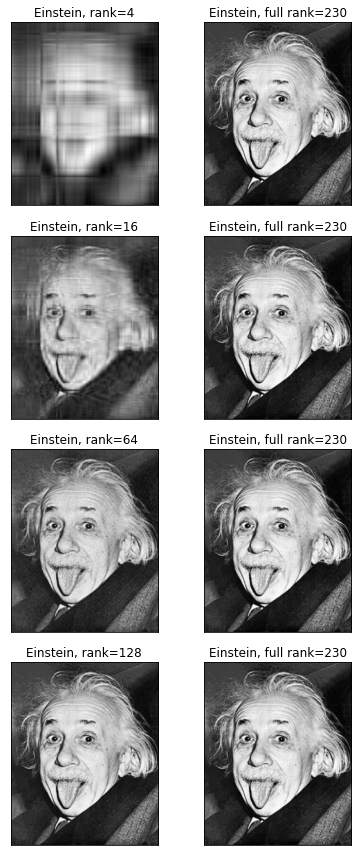

In [24]:
def low_rank(U, Sigma, VT, k):
    """
    low_rank returns a low rank approximation based on the top k singular values

    :param U: numpy.ndarray      Matrix U of left singular vectors
    :param Sigma: numpy.ndarray  Matrix Sigma of singular values
    :param VT: numpy.ndarray     Matrix VT of right singular vectors
    :param k: int                Number of singular values
    :return: numpy.ndarray       Low-rank approximation of original matrix
    """
    A = U[:,:k] @ np.diag(Sigma[:k]) @ VT[:k,:]
    return A


U, Sigma, VT = np.linalg.svd(einstein)

ranks = [4, 16, 64, 128]
# Plot the original matrix and low rank approximations.
# NOTE(mmorais): Hide ticks around images and hide axes without plot.
fig1, axes = plt.subplots(len(ranks), 2, figsize=(6,12), 
                          subplot_kw={'xticks':[], 'yticks': []})

for i, k in enumerate(ranks):
    A = low_rank(U, Sigma, VT, k)
    axes[i,0].imshow(A, cmap='gray')
    axes[i,0].set_title(f'Einstein, rank={k}')
    axes[i,1].imshow(einstein, cmap='gray')
    axes[i,1].set_title(f'Einstein, full rank={Sigma.size}')

plt.tight_layout()
plt.show()

> Create a scree plot of % normalized singular values. Test various thresholds for reconstructing the image. What threshold seems reasonable?

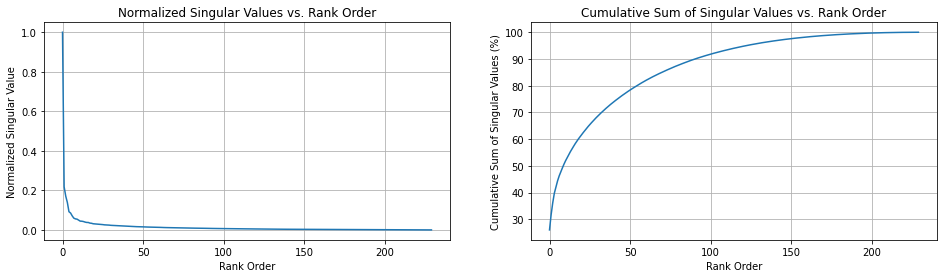

In [25]:
Sigma_cumsum = np.cumsum(Sigma)
ranks = np.arange(Sigma.size)

fig1, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].plot(ranks, Sigma/Sigma[0])
axes[0].set_title('Normalized Singular Values vs. Rank Order')
axes[0].set_ylabel('Normalized Singular Value')
axes[0].set_xlabel('Rank Order')
axes[0].grid()
axes[1].plot(ranks, 100.*Sigma_cumsum/Sigma_cumsum[-1])
axes[1].set_title('Cumulative Sum of Singular Values vs. Rank Order')
axes[1].set_ylabel('Cumulative Sum of Singular Values (%)')
axes[1].set_xlabel('Rank Order')
axes[1].grid(which='both')
plt.show()

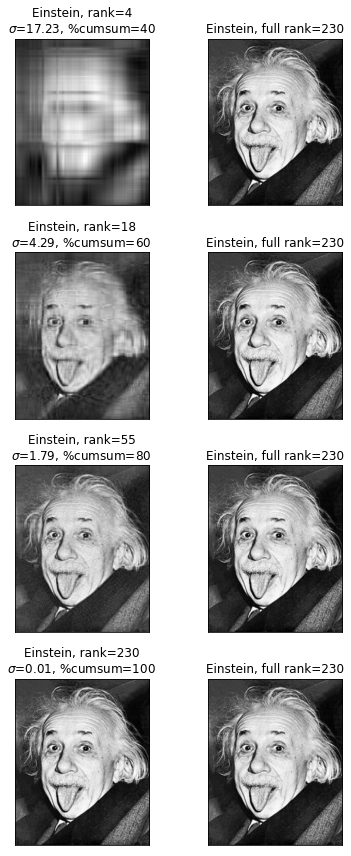

In [26]:
pcnts = [40, 60, 80, 100]
pcnt_cumsum = 100.*Sigma_cumsum/Sigma_cumsum[-1]

# Plot the original matrix and low rank approximations.
# NOTE(mmorais): Hide ticks around images and hide axes without plot.
fig1, axes = plt.subplots(len(pcnts), 2, figsize=(6,12), 
                          subplot_kw={'xticks':[], 'yticks': []})

for i, pcnt in enumerate(pcnts):
    inds = np.where(pcnt_cumsum <= pcnt)
    k, sigma = inds[0][-1], Sigma[inds[0][-1]]
    A = low_rank(U, Sigma, VT, inds[0][-1])
    axes[i,0].imshow(A, cmap='gray')
    axes[i,0].set_title(f'Einstein, rank={k+1}\n$\sigma$={sigma:.2f}, %cumsum={pcnt}')
    axes[i,1].imshow(einstein, cmap='gray')
    axes[i,1].set_title(f'Einstein, full rank={Sigma.size}')

plt.tight_layout()
plt.show()

> The final challenge is to make the assessments of the number of appropriate components more quantitative. Compute the error between the reconstruction and the original image. The error can be operationalized as the RMS (root mean square) of the difference map. The difference map is formed by subtracting the low rank approximation from the original image. plot the RMS as a function of the number of singular values used to approximate the original image.

In [27]:
def rms(img1, img2):
    """
    rms returns the root mean square of the difference between a pair of images

    :param img1: numpy.ndarray  Image
    :param img2: numpy.ndarray  Image
    :return: float              RMS
    """
    assert img1.shape == img2.shape, "image dimensions not compatible"
    diff = img1 - img2
    rms = np.linalg.norm(diff.flatten()) / np.sqrt(diff.size)
    return rms

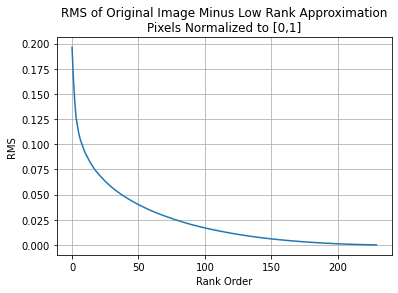

In [28]:
rms_per_rank = np.zeros(Sigma.size)
ranks = np.arange(Sigma.size)

for i in range(Sigma.size):
    A = low_rank(U, Sigma, VT, i+1)
    rms_per_rank[i] = rms(einstein, A)

plt.plot(ranks, rms_per_rank)
plt.title('RMS of Original Image Minus Low Rank Approximation\nPixels Normalized to [0,1]')
plt.ylabel('RMS')
plt.xlabel('Rank Order')
plt.grid()
plt.show()

> What is the pseudoinverse of a column vector of constants? That is, the pseudoinverse of k1. It obviously doesn't have a full inverse, but it is clearly a full column-rank matrix. First, work out your answer on paper, then confirm with code.

In [29]:
m, n, k = 5, 1, 2.
A = k * np.ones((m,n))

Aplus = np.linalg.pinv(A)

# Verify that the product of the pseudoinverse of column vector 
# and the column vector is equivalent to the dot product.
np.testing.assert_almost_equal(Aplus @ A, 1.0)

# Verify that the elements of the pseudoinverse are 1/(km).
np.testing.assert_equal(Aplus.size, m)
np.testing.assert_almost_equal(Aplus[0,0], 1./(k*m))

> Implement the series of equations on page 502 and confirm that you get the same result as with the `pinv()` function. Start by creating a $4 \times 2$ matrix of random integers between 1 and 6. Then compute the SVD. Then implement each of the next four equations in code. Finally compute the Moore-Penrose pseudoinverse of the tall matrix. You will now have five versions of the pseudoinverse; make sure they are all equal.

In [30]:
m, n = 4, 2
A = np.random.randint(1, 6, size=m*n).reshape(m, n)

U, Sigma, VT = np.linalg.svd(A, full_matrices=False)

Aprime = U @ np.diag(Sigma) @ VT

# Equation 16.30: Left inverse of tall matrix.
Aplus1 = np.linalg.inv(Aprime.T @ Aprime) @ Aprime.T
np.testing.assert_almost_equal(Aplus1, np.linalg.pinv(A))

# Equation 16.31: Expand transpose of product of matrices using LIVE EVIL.
Aplus2 = np.linalg.inv(VT.T @ np.diag(Sigma).T @ U.T @ U @ np.diag(Sigma) @ VT) @ VT.T @ np.diag(Sigma) @ U.T
np.testing.assert_almost_equal(Aplus2, np.linalg.pinv(A))

# Equation 16.32: Eliminate product of orthogonal matrices.
Aplus3 = np.linalg.inv(VT.T @ np.diag(Sigma * Sigma) @ VT) @ VT.T @ np.diag(Sigma) @ U.T
np.testing.assert_almost_equal(Aplus3, np.linalg.pinv(A))

# Equation 16.33: Expand inverse of product of matrices using LIVE EVIL.
Aplus4 = VT.T @ np.linalg.inv(np.diag(Sigma * Sigma)) @ VT @ VT.T @ np.diag(Sigma) @ U.T
np.testing.assert_almost_equal(Aplus4, np.linalg.pinv(A))

# Equation 16.34: Eliminate product of orthogonal matrices.
Aplus5 = VT.T @ np.linalg.inv(np.diag(Sigma)) @ U.T
np.testing.assert_almost_equal(Aplus5, np.linalg.pinv(A))

# Verify that Aplus @ A = I where dimension of identity matrix is rank(A) = min(m,n).
rank = np.min([m,n])
np.testing.assert_almost_equal(Aplus5 @ A, np.eye(rank))